# Обнаружение каверов музыкальных треков

## Задача

Обнаружение треков каверов - важная продуктовая задача, которая может значительно улучшить качество рекомендаций музыкального сервиса и повысить счастье наших пользователей. Если мы умеем с высокой точностью классифицировать каверы и связывать их между собой, то можно предложить пользователю новые возможности для управления потоком треков. Например:

- по желанию пользователя можем полностью исключить каверы из рекомендаций;
- показать все каверы на любимый трек пользователя;
- контролировать долю каверов в ленте пользователя.

## Цель
В этом хакатоне нам предлагается разработать решение, которое:

- может классифицировать треки по признаку кавер-некавер;
- связывать (группировать) каверы и исходный трек;
- находит исходный трек в цепочке каверов.

Нам требуется разработать ML-модель для сопоставления текстов музыкальных произведений и для поиска каверов (вариации обработки оригинала с элементами новой аранжировки) по их текстам. 

Для решения этой задачи мы можем использовать любые открытые источники данных и собирать необходимую вам информацию, соблюдая правила использования сервисов, которые эту информацию предоставляют.

Данные предоставлены заказчиком в трех файлах: covers.json, meta.json, lyrics.json.

### Разметка каверов

Файл covers.json содержит разметку каверов, сделанную редакторами сервиса:

- track_id - уникальный идентификатор трека;
- track_remake_type - метка, присвоенная редакторами. Может принимать значения ORIGINAL и COVER;
- original_track_id - уникальный идентификатор исходного трека.

Обратите внимание, что не для всех каверов известны идентификаторы исходных треков!!!

### Метаинформация
Файл meta.json 
- track_id - уникальный идентификатор трека;
- dttm - первая дата появления информации о треке;
- title - название трека;
- language - язык исполнения;
- isrc - международный уникальный идентификатор трека;
- genres - жанры;
- duration - длительность трека;

### Текст песен
Файл lyrics.json
- track_id - уникальный идентификатор трека;
- lyricId - уникальный идентификатор текста;
- text - текст трека.

**Исследование пройдет в 7 этапов:**

* загрузка и первичное ознакомление с данными,
* предварительная обработка,
* полноценный разведочный анализ,
* разработка новых синтетических признаков,
* проверка на мультиколлинеарность,
* отбор финального набора обучающих признаков,
* выбор и обучение моделей,
* итоговая оценка качества предсказания лучшей модели,
* анализ важности ее признаков.
* общий вывод

## Загрузка и первичное ознакомление с данными

Импортируем необходимые для анализа данных библиотеки. Введем константу RANDOM_STATE = 54321.

In [1]:
import json
import os

import warnings
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
import sys
#!{sys.executable} -m pip install spacy

#!{sys.executable} -m spacy download en
import spacy

from sklearn.dummy import DummyClassifier
from catboost import CatBoostClassifier
from catboost import Pool
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    KFold,
    RandomizedSearchCV
)
from sklearn.metrics import (
    accuracy_score,
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score,
    roc_curve, 
    precision_recall_curve,
    confusion_matrix,
    ConfusionMatrixDisplay
)
RANDOM_STATE = 54321
from tqdm.notebook import tqdm
tqdm.pandas()
import scipy.sparse as sp


from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

warnings.filterwarnings("ignore")

Считаем данные из json-файлов в датафреймы и сохраним в переменные. Пропишем пути.

In [2]:
path_covers = 'C:\\Users\\fudou\\Untitled Folder 1\\covers.json'
path_meta = 'C:\\Users\\fudou\\Untitled Folder 1\\/meta.json'
path_lyrics = 'C:\\Users\\fudou\\Untitled Folder 1\\/lyrics.json'

In [3]:
# выберем стиль для оформления графиков
plt.style.use('fivethirtyeight')

## Первичный обзор данных

In [4]:
# разметка каверов
df_covers = pd.read_json(path_covers, lines=True)
# посмотрим 3 случайные строки
df_covers.sample(3)

,original_track_id,track_id,track_remake_type
40869,None,f8394887fdfde1010ea3ba2184921a5f,COVER
37626,None,4ddf57551696894ec0b5c8fac16ea236,COVER
54092,None,8f76f85c90f84c8ef401df1f2c969058,COVER


В датасете метаинфомация есть столбец с dttm - первая дата появления информации о треке. При чтении файла JSON, pandas изначально интерпретирует все значения столбца 'dttm' как строки (строковый тип данных), поэтому сразу конвертируем строковый тип данных в тип данных даты (datetime).

In [5]:
# метаинформация
df_meta = pd.read_json(path_meta, lines=True, convert_dates=['dttm'])
df_meta.sample(3)

,track_id,dttm,title,language,isrc,genres,duration
60965,837c2bda8400cf7a1355055cd3d61345,2021-02-01 21:00:00,Jesus Of Nazareth,EN,DGA072119116,"[FILMS, SOUNDTRACK]",28000.0
14702,0c60a58723d8256035c8136fb69e50c1,2022-08-12 01:35:26,"Juliet e Chapelão (Bota, Bota)",None,QZNJY2291193,"[FOLK, LATINFOLK]",135820.0
46454,8c8fb1c4f6cba0077274c0991eb328b5,2014-10-20 20:00:00,Santa Claus Is Coming to Town,EN,USRE11100701,"[JAZZ, VOCALJAZZ]",171090.0


In [6]:
# тексты трека
df_lyrics = pd.read_json(path_lyrics, lines=True)
df_lyrics.sample(3)

,lyricId,text,track_id
3766,4d70c3c5003534a36688218b1c697cc4,I've been your girlfriend\nFor quite a while\n...,a315487f8cf61d8bbbf1468546607062
5515,97c7fba3bc579b9468a2dd87ddb81ef1,"Дыши со мной в унисон ещё, ещё и ещё\nПотратим...",cb4fd8b6b3ac80ea3aeb0efa7f2a22be
3018,c90db9767932d87969d1a371ff68945f,I sat all alone\nOutside of your home\nWaiting...,e655a93554dc1c0f3b79cb87fd945f07


In [7]:
# напишем функцию для вывода основной информации о датасетe
def main_info(data):
    print(f'Выведем первые 5 строк датафрейма')
    display(data.head())
    print()

    print(f'Основная информация о датафрейме')
    print()
    display(data.info())
    print()

    print(f'Числовое описание данных')
    display(data.describe().style.background_gradient())
    print()

    print(f'Количество строк-дубликатов')
    display(data.duplicated().sum())
    print()

    print(f'Количество пропусков в процентном соотношении')
    display(pd.DataFrame(round(data.isna().mean()*100,1)).style.background_gradient())
    print()

**Обзор датасета разметки каверов**

In [8]:
# посмотрим датасет c каверами
main_info(df_covers)

Выведем первые 5 строк датафрейма


,original_track_id,track_id,track_remake_type
0,eeb69a3cb92300456b6a5f4162093851,eeb69a3cb92300456b6a5f4162093851,ORIGINAL
1,fe7ee8fc1959cc7214fa21c4840dff0a,fe7ee8fc1959cc7214fa21c4840dff0a,ORIGINAL
2,cd89fef7ffdd490db800357f47722b20,cd89fef7ffdd490db800357f47722b20,ORIGINAL
3,995665640dc319973d3173a74a03860c,995665640dc319973d3173a74a03860c,ORIGINAL
4,None,d6288499d0083cc34e60a077b7c4b3e1,COVER



Основная информация о датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71597 entries, 0 to 71596
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   original_track_id  4821 non-null   object
 1   track_id           71597 non-null  object
 2   track_remake_type  71597 non-null  object
dtypes: object(3)
memory usage: 1.6+ MB


None


Числовое описание данных


,original_track_id,track_id,track_remake_type
count,4821,71597,71597
unique,4468,71597,2
top,f3e5e9db509f9b6f6d93b9c38e4e1324,a90742aed4267fbcd9c539f7e12550aa,COVER
freq,38,1,67304



Количество строк-дубликатов


0


Количество пропусков в процентном соотношении


,0
original_track_id,93.300000
track_id,0.000000
track_remake_type,0.000000


In [9]:
# проверим дубликаты по `track_id`
df_covers['track_id'].duplicated().sum()

0

In [10]:
# проверим дубликаты по `original_track_id`
df_covers['original_track_id'].duplicated().sum()

67128

Посмотрим, сколько строк с разметкой COVER имеют ненулевой столбец original_track_id.

In [11]:
df = df_covers[df_covers['track_remake_type']=='COVER']
df[~df['original_track_id'].isna()].shape[0]

528

Получили 528 строк-каверов у которых есть ссылка на оригинал. Остальные (66776) без разметки.

Также рассмотрим ситуацию когда от одного оригинала делается несколько каверов.

In [12]:
df_group = df_covers.groupby('original_track_id')['track_id'].agg('count').reset_index()
df_group = df_group.sort_values('track_id')
# посмотрим топ количества каверов на 1 оригинал трека
df_group = df_group.tail(20)
df_group.describe()

,track_id
count,20.000000
mean,16.250000
std,11.433446
min,3.000000
25%,3.750000
50%,15.500000
75%,25.000000
max,38.000000


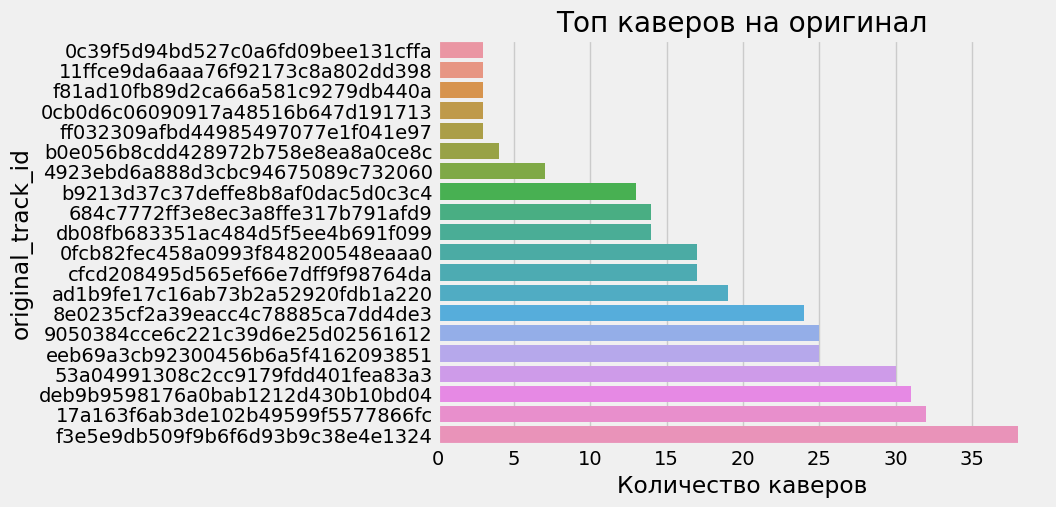

In [13]:
plt.figure(figsize=(7,5))
sns.barplot(x =df_group['track_id'],y =df_group['original_track_id']);
plt.title ('Топ каверов на оригинал');
plt.xlabel ('Количество каверов');
plt.ylabel ('original_track_id');
plt.show()

Максимальное количество каверов составляет 38 штук, далее идет на убывание. В среднем треки имеют около 16 каверов.

**Вывод** 

Датасет с разметкой каверов содержит 71597 объектов и 3 столбца.       

Столбец `original_track_id`: обнаружено **93 %** пропусков (это подтверждается данными от заказчика о том, что не для всех каверов известны идентификаторы исходных треков. При этом 4468 значения являются уникальными из 4821 имеющихся данных.    
Столбец `track_id` - все уникальны,пропусков нет.   
Столбец `track_remake_type` - имеется 2 значения: COVER и ORIGINAL. Наблюдается дисбаланс, каверов 67304. 

Строки с полными дубликатами отсутствуют. 

**Обзор датасета 'Метаинформация'** 

Доделать анализ по столбцам!+ графики+ что делать с жанрами
почистить неявные дубликаты в названиях

In [14]:
df_meta.head()

,track_id,dttm,title,language,isrc,genres,duration
0,c3b9d6a354ca008aa4518329aaa21380,2021-12-16 21:00:00,Happy New Year,EN,RUB422103970,[DANCE],161120.0
1,c57e3d13bbbf5322584a7e92e6f1f7ff,2021-11-24 14:00:33,Bad Habits,EN,QZN882178276,[ELECTRONICS],362260.0
2,955f2aafe8717908c140bf122ba4172d,2021-11-24 15:37:03,Por Esa Loca Vanidad,None,QZNJZ2122549,"[FOLK, LATINFOLK]",260000.0
3,fae5a077c9956045955dde02143bd8ff,2021-11-24 15:37:03,Mil Lagrimas,None,QZNJZ2166033,"[FOLK, LATINFOLK]",190000.0
4,6bede082154d34fc18d9a6744bc95bf5,2021-11-24 15:37:03,Sexo Humo y Alcohol,None,QZNJZ2122551,"[FOLK, LATINFOLK]",203000.0


In [15]:
# посмотрим датасет c метаинформацией
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71769 entries, 0 to 71768
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   track_id  71768 non-null  object        
 1   dttm      71768 non-null  datetime64[ns]
 2   title     71768 non-null  object        
 3   language  21969 non-null  object        
 4   isrc      71455 non-null  object        
 5   genres    71768 non-null  object        
 6   duration  71768 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 3.8+ MB


In [16]:
print(f'Количество пропусков в процентном соотношении')
display(pd.DataFrame(round(df_meta.isna().mean()*100,1)).style.background_gradient())


Количество пропусков в процентном соотношении


,0
track_id,0.000000
dttm,0.000000
title,0.000000
language,69.400000
isrc,0.400000
genres,0.000000
duration,0.000000


In [17]:
df_meta['genres']

0                  [DANCE]
1            [ELECTRONICS]
2        [FOLK, LATINFOLK]
3        [FOLK, LATINFOLK]
4        [FOLK, LATINFOLK]
               ...        
71764              [INDIE]
71765                [POP]
71766        [ALTERNATIVE]
71767        [ALTERNATIVE]
71768        [POP, RUSPOP]
Name: genres, Length: 71769, dtype: object

In [18]:
# функция для очистки жанров и склеивание в 1строку
def clean_genres(df):
    # Применение функции clean_categories к столбцу 'genres'
    df['genres'] = df['genres'].apply(lambda x: re.sub(r'\[|\]', '', str(x)))
    df['genres'] = df['genres'].apply(lambda x: re.sub(r',', '', str(x).lower()))
    df['genres'] = df['genres'].apply(lambda x: x.replace("'", ""))  # Удаление кавычек
    df['genres'] = df['genres'].str.replace(' ', '').str.strip()
    return df


df_meta = clean_genres(df_meta)
print(df_meta['genres'])

0                dance
1          electronics
2        folklatinfolk
3        folklatinfolk
4        folklatinfolk
             ...      
71764            indie
71765              pop
71766      alternative
71767      alternative
71768        popruspop
Name: genres, Length: 71769, dtype: object


**Вывод** Дописать после обзора!  

Датасет с метаинфромацией содержит 71768 объектов и 7 столбцов, пропуски присутствуют в 2х столбцах:language и isrc (международный id трека).   

**Обзор датасета 'Тексты песен'** Доделать анализ

In [19]:
# посмотрим датасет c текстами
main_info(df_lyrics)

Выведем первые 5 строк датафрейма


,lyricId,text,track_id
0,a951f9504e89759e9d23039b7b17ec14,"Живу сейчас обломами, обломками не той любви\n...",1c4b1230f937e4c548ff732523214dcd
1,0c749bc3f01eb8e6cf986fa14ccfc585,Tell me your fable\nA fable\nTell me your fabl...,0faea89b0d7d6235b5b74def72511bd8
2,e2c8830fbc86e5964478243099eec23a,You're ashamed about all your fears and doubts...,9c6dc41d5ccd9968d07f055da5d8f741
3,e2c8830fbc86e5964478243099eec23a,You're ashamed about all your fears and doubts...,bfd04a73e9cffdf0e282c92219a86ea1
4,7624653ca8522ba93470843c74961b7d,"You showed him all the best of you,\nBut I'm a...",8d70930d09cd239c948408d1317d8659



Основная информация о датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11414 entries, 0 to 11413
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   lyricId   11414 non-null  object
 1   text      11414 non-null  object
 2   track_id  11414 non-null  object
dtypes: object(3)
memory usage: 267.6+ KB


None


Числовое описание данных


,lyricId,text,track_id
count,11414,11414,11414
unique,10915,10644,10277
top,28fbafaf626c497d0d4d933b4f0d3f5b,"Twenty-five years and my life is still I'm trying to get up that great big hill of hope For a destination And so I wake in the morning And I step outside And I take a deep breath and I get real high And I scream at the top of my lungs What's going on? And I say, hey hey hey hey, hey hey hey hey I said hey, what's going on? And I say, hey hey, hey hey What's going on? What's going on? And I say, hey hey, hey hey, hey hey, hey hey, hey hey, hey hey What's going on?",b891000882f4a612190142861b5c038b
freq,9,15,24



Количество строк-дубликатов


0


Количество пропусков в процентном соотношении


,0
lyricId,0.000000
text,0.000000
track_id,0.000000


Тексты песен на разных языках. Сделали перевод.

In [20]:
df_translated = pd.read_csv('translated_lyrics.csv')

In [21]:
main_info(df_translated)

Выведем первые 5 строк датафрейма


,track_id,language,lyricId,text,translate_text
0,c3b9d6a354ca008aa4518329aaa21380,EN,36777cce0740d1e3d37a5a221c71d859,No more champagne\nAnd the fireworks are throu...,No more champagne\nAnd the fireworks are throu...
1,c57e3d13bbbf5322584a7e92e6f1f7ff,EN,8284927611c6a6fc49ff1ce7b3a88314,"Ooh-ooh, ooh, ooh\n\nEvery time you come aroun...","Ooh-ooh, ooh, ooh\n\nEvery time you come aroun..."
2,a7309d9c3374e12201f3226bc0fa7980,ES,0d2749ebc9b46feace9bd029693a720e,En el nombre del cielo os pido posada\nPues no...,In the name of heaven I ask you inn\nFor my be...
3,0c0315f45a49a35901912d0084cdf03f,PT,93768c946e484136b33ec7aa5b79be73,És inegualável\nNa arte de amar\nSou tão feliz...,You're unbeatable\nIn the art of loving\nI'm s...
4,94093810e71074bec5a6990c1c214165,HI,4099131cd860fc6194ad926e28efbe2f,Music\n\nSun mere humsafar\nKya tujhe itni si ...,Music\n\nSun mere humsafar\nKya tujhe itni si ...



Основная информация о датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11414 entries, 0 to 11413
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   track_id        11414 non-null  object
 1   language        11359 non-null  object
 2   lyricId         11414 non-null  object
 3   text            11414 non-null  object
 4   translate_text  11414 non-null  object
dtypes: object(5)
memory usage: 446.0+ KB


None


Числовое описание данных


,track_id,language,lyricId,text,translate_text
count,11414,11359,11414,11414,11414
unique,10277,57,10915,10644,10665
top,b891000882f4a612190142861b5c038b,EN,6fe05ce48761f833737487cd7a499cd3,"Twenty-five years and my life is still I'm trying to get up that great big hill of hope For a destination And so I wake in the morning And I step outside And I take a deep breath and I get real high And I scream at the top of my lungs What's going on? And I say, hey hey hey hey, hey hey hey hey I said hey, what's going on? And I say, hey hey, hey hey What's going on? What's going on? And I say, hey hey, hey hey, hey hey, hey hey, hey hey, hey hey What's going on?","Twenty-five years and my life is still I'm trying to get up that great big hill of hope For a destination And so I wake in the morning And I step outside And I take a deep breath and I get real high And I scream at the top of my lungs What's going on? And I say, hey hey hey hey, hey hey hey hey I said hey, what's going on? And I say, hey hey, hey hey What's going on? What's going on? And I say, hey hey, hey hey, hey hey, hey hey, hey hey, hey hey What's going on?"
freq,24,7137,9,15,15



Количество строк-дубликатов


0


Количество пропусков в процентном соотношении


,0
track_id,0.000000
language,0.500000
lyricId,0.000000
text,0.000000
translate_text,0.000000


In [22]:
# загрузим объект nlp
disabled_pipes = ['parser','ner']
nlp = spacy.load("en_core_web_sm",disable=disabled_pipes)

# напишем функцию
def lemmatize(text):
    text = text.lower()
    text = nlp(text)
    lemm_text = " ".join([token.lemma_ for token in text])
    clear_text = re.sub(r'[^a-zA-Z ]', ' ', lemm_text)
    return  " ".join(clear_text.split())          

Создадим новый столбец lemm_text с обработанным текстом, который будет нашим основным признаком для модели.

In [23]:
#tqdm.pandas("lemmatize")
df_translated['lemm_text'] = df_translated['translate_text'].progress_apply(lemmatize) 

  0%|          | 0/11414 [00:00<?, ?it/s]

In [ ]:
# проверим работу функции на произвольной строке
print("Исходный текст:", df_translated['text'][7])
print("Очищенный и лемматизированный текст:", lemmatize(df_translated['translate_text'][47]))

In [ ]:
df_translated.duplicated().sum()

In [ ]:
df_translated.info()

In [24]:
# удалим столбец с изначальным текстом и переведенным
df_translated = df_translated.drop(['translate_text','text'], axis=1)

**Вывод** Дописать про перевод, добавить про разные языки, после анализа

Датасет с текстами песен содержит около 99% уникальных значений текстов и 95% уникальных значений lyricId.         
Названия колонок соответствуют первоначальному описанию данных. 
Сразу видим, что есть одинаковые на первый взгляд тексты песен, при этом track_id у них разный, а lyricId одинаковый.	             

Типы данных соответствуют содержанию.            
Полных строк дубликатов в тексте песен нет. Но при ближайшем рассмотрении по столбцам, дубликаты видны
Cтолбец `language` имеет 0,5% пропусков.
Все тексты были переведены на английский язык, проведена лемматизация.

### Исследовательский анализ данных
Рассмотрим подробно имеющиеся столбцы

In [25]:
# все дубликаты без пропусков с длительностью больше 0
df_meta[df_meta['isrc'].duplicated(keep=False) & df_meta['isrc'].notna() & df_meta['duration'] > 0].sort_values(by='isrc')

,track_id,dttm,title,language,isrc,genres,duration
27012,be0233f57dbb59079929ac646b0b9d5c,2021-07-06 16:38:30,Zivot da stane ne sme,None,ATAJ12100470,folk,151190.0
26955,8aff9d28865aaf1fa44e46b82cba0f63,2021-07-06 15:38:37,Burma,None,ATAJ12100470,folk,179300.0
51052,196a0973d73122891a426f8334105ce7,2019-03-29 21:00:00,Inní mér syngur vitleysingur,EN,ATN261668711,folkmetalmetal,237010.0
66395,425761c88ebc69e89c748eb537671953,2018-04-28 19:08:26,Inni Mer Syngur Vitleysingur,None,ATN261668711,folkmetalmetal,237010.0
51053,aa4a1d4d44890cbc7aae285842bd3ce2,2019-03-29 21:00:00,Nattfödd,EN,ATN261668712,folkmetalmetal,255320.0
...,...,...,...,...,...,...,...
42673,9ca51834e2b6a7266ebcb10cf9a00409,2014-09-23 12:08:24,How Far We've Come,None,USTCF1018560,rockallrock,200820.0
42671,2e04e2ca902c24028b3a7bcded51deeb,2014-09-23 12:08:24,Angel,None,USTCF1018563,rockallrock,261490.0
67314,7eb1ce7b0e7ce4c053c1c9af0ebd9634,2018-11-08 18:31:51,Angel (2009),EN,USTCF1018563,rockallrock,261450.0
67315,90117fc7a8a5ef80c4d3e1e6e39b4f06,2018-11-08 18:31:51,Breathe (2009),EN,USTCF1018565,rockallrock,221970.0


In [ ]:
# все дубликаты без пропусков в lyricId	
df_lyrics[df_lyrics['lyricId'].duplicated(keep=False) & df_lyrics['track_id'].notna() & df_lyrics['text'].notna()].sort_values(by='track_id')

Обнаружили, что одному isrc может соответствовать несколько уникальных track_id. Это может быть вызвано дублем загрузки или несколько источников текста.

**Объединение датасетов**   

Все датасеты содержат общий столбец `track_id`.Объединим датафреймы по столбцу `track id`, при этом удалим все дубликаты в этом столбце.

**Внимание!** Нужно оставлять дубликат в котором меньше всего пропусков в других признаках.

In [26]:
# объединяем и оставляем тот дубликат, в котором меньше пропусков
df_union = df_covers.merge(df_meta, on='track_id', how='inner').merge(df_translated, on='track_id', how='inner')

df_duplicated = df_union.duplicated(subset='track_id', keep=False)
df_duplicates_counts = df_union[df_duplicated].isnull().sum(axis=1)

df_union = df_union[~df_duplicated | (df_duplicates_counts == df_duplicates_counts.min())]


In [27]:
# объединим датафреймы по столбцу `track id`
#df_merged = pd.merge(df_covers, df_meta, on='track_id',how='left')

# выведем объединенный датафрейма
#df_merged.head()

In [28]:
#df_union = pd.merge(df_merged, df_lyrics, on='track_id',how='left')

In [29]:
df_union.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10229 entries, 0 to 11096
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   original_track_id  3417 non-null   object        
 1   track_id           10229 non-null  object        
 2   track_remake_type  10229 non-null  object        
 3   dttm               10229 non-null  datetime64[ns]
 4   title              10229 non-null  object        
 5   language_x         6553 non-null   object        
 6   isrc               10183 non-null  object        
 7   genres             10229 non-null  object        
 8   duration           10229 non-null  float64       
 9   language_y         10180 non-null  object        
 10  lyricId            10229 non-null  object        
 11  lemm_text          10229 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(10)
memory usage: 1.0+ MB


In [ ]:
# проверим размер итоговой таблицы
df_union.shape

**Получилось чуть больше значений чем у Алексея**

Посмотреть дубликаты по всему датасету не представляется возможным. Посмотрим отдельно по столбцам.

In [ ]:
# проверим дубликаты по `track_id`
df_union['track_id'].duplicated().sum()

Было 974 при предыдущем объединении когда все дубликаты оставались.

In [ ]:
df_union['track_id'].drop_duplicates(inplace=True)


In [ ]:
df_union['track_id'].duplicated().sum()

In [ ]:
df_union['title'].duplicated().sum()

После объединения всех датафреймов в 1 мы получили больше информации об имеющихся у нас треках.

In [ ]:
df_group = df_union.groupby('original_track_id')['track_id'].agg('count').reset_index()
df_group = df_group.sort_values('track_id')
df_group = df_group.tail(20)

In [ ]:
plt.title('Топ 10 количество каверов для оригинального трека')
plt.barh(df_group['original_track_id'], df_group['track_id'])
plt.xlabel('Количество треков')
plt.ylabel('id оригинального трека')
plt.show()

In [ ]:
grouped_data = df_union.groupby(['track_remake_type'])['original_track_id'].value_counts()

grouped_data.head()

In [ ]:
# cгруппировали данные по количеству названий песен для категории кавер-оригинал
grouped_data1 = df_union.groupby(['track_remake_type'])['title'].value_counts()
grouped_data1 

In [ ]:
grouped_data2 = df_union.groupby(['track_remake_type'])['track_id'].value_counts()
grouped_data2 

In [ ]:
# cгруппировали данные по количеству песен в определенную дату
grouped_data3 = df_union.groupby(['track_remake_type'])['dttm'].value_counts()
grouped_data3 

In [ ]:
# cгруппировали данные по количеству названий песен для категории кавер-оригинал
grouped_data3 = df_union.groupby(['dttm'])['track_remake_type'].value_counts()
grouped_data3 



Перед нами стоит задача бинарной классификации. Явного таргета у нас нет, поэтому нам следует сгенерировать новый бинарный признак по столбцу track_remake_type. Следовательно, создадим новый столбец, где '1' - COVER, а '0' - ORIGINAL. После этого удалить столбец 'track_remake_type'.

In [30]:
df_union['target'] = np.where(df_union['track_remake_type']== 'ORIGINAL',0,1)

In [ ]:
df_union.info()

In [31]:
# посмотрим пропуски
df_union.isna().sum() 

original_track_id    6812
track_id                0
track_remake_type       0
dttm                    0
title                   0
language_x           3676
isrc                   46
genres                  0
duration                0
language_y             49
lyricId                 0
lemm_text               0
target                  0
dtype: int64

In [ ]:
df_union['isrc'].duplicated().sum()

In [ ]:
# проверим дубликаты по 'original_track_id'
df_union['original_track_id'].duplicated().sum()

In [ ]:
# посмотрим период за который у нас есть данные 
max_date = df_union['dttm'].max()
min_date = df_union['dttm'].min()
print(f'Данные представлены за период c {min_date} по {max_date}')

**Подготовка признаков для обучения Baseline модели**

**Изучим, что такое ISRC**    
ISRC – уникальный код, который однозначно и навсегда определяет музыкальную или видеозапись.

Именно запись, не песню в целом. Разным версиям одной песни или видео (ремиксы, вырезки и т. д.) должны быть присвоены различные уникальные кодыКод можно присваивать записи как сразу после ее написания, так и «задним числом» – через любой промежуток времени после ее публикации.
– ISRC является самым простым и оперативным способом идентификации владельца прав на музыкальное или видео произведение в случае, если после присвоения кода владелец прав не менялся.

– В большинстве случаев, с помощью кода можно определить год и страну написания записи.
.

ISRC RU — B94 — 13 — 00137 (ISRC RUB941300137)
ISRC RU B94 13 00137
Идентификатор кода Код страны (2 буквы)RU = Россия Код регистранта(3 символа)B94 = Концертно-продюсерский центр Год присваивания кода(2 цифры)13 = 2013 Номер записи(5 цифр). 

In [32]:
# Извлекаем год из столбца isrc
df_union['year_of_track'] = df_union['isrc'].str[5:7]
df_union['year_of_track'].unique()

array(['69', '04', '07', '01', '99', '70', '05', '98', '08', '68', '93',
       '90', '86', '67', '03', '94', '60', '02', '00', '06', '79', '95',
       '65', '80', '74', '89', '91', '87', '88', '58', '97', '57', '84',
       '09', '96', None, '51', '92', '81', '73', '10', '18', '82', '83',
       '85', '44', '76', '75', '15', '13', '16', '11', '12', '5-', '14',
       '17', '19', '21', '22', '23', '24', '33', '20', '71', '30', '63',
       '78', '77'], dtype=object)

**Внимание исправить значение 5-, удалить его?**

Напишем функцию, которая преобразовывает столбец с годом в 4-х значный, исходя из имеющихся сведений об isrc.

In [33]:
def transform_year(year):
    if year is None:
        return '0'
    elif year.isdigit() and int(year) >= 0 and int(year) <= 23:
        return '20' + year
    else:
        return '19' + year

df_union['year_of_track'] = df_union['year_of_track'].apply(transform_year)

In [34]:
# исправить значение 195-, удалить его?
df_union['year_of_track'].unique()

array(['1969', '2004', '2007', '2001', '1999', '1970', '2005', '1998',
       '2008', '1968', '1993', '1990', '1986', '1967', '2003', '1994',
       '1960', '2002', '2000', '2006', '1979', '1995', '1965', '1980',
       '1974', '1989', '1991', '1987', '1988', '1958', '1997', '1957',
       '1984', '2009', '1996', '0', '1951', '1992', '1981', '1973',
       '2010', '2018', '1982', '1983', '1985', '1944', '1976', '1975',
       '2015', '2013', '2016', '2011', '2012', '195-', '2014', '2017',
       '2019', '2021', '2022', '2023', '1924', '1933', '2020', '1971',
       '1930', '1963', '1978', '1977'], dtype=object)

In [35]:
df_union['year_of_track']

0        1969
1        1969
2        1969
3        2004
4        2007
         ... 
11092    2023
11093    2000
11094    2023
11095    2023
11096    2000
Name: year_of_track, Length: 10229, dtype: object

**!!!перевести тип данных в числовой формат, т.к.это не категория после исправления 195-**

In [ ]:
#df_union['year_of_track'] = df_union['year_of_track'].astype('int64')

In [36]:
# Извлекаем страну из столбца isrc
df_union['country_of_track'] = df_union['isrc'].str[0:2]
df_union['country_of_track'] 

0        US
1        US
2        US
3        US
4        US
         ..
11092    RU
11093    SM
11094    RU
11095    RU
11096    SM
Name: country_of_track, Length: 10229, dtype: object

In [37]:
# Извлекаем код регистранта из столбца isrc
df_union['reg_code'] = df_union['isrc'].str[3:6]
df_union['reg_code'] 

0        I86
1        I86
2        I86
3        L10
4        M70
        ... 
11092    1D2
11093    US0
11094    GV2
11095    GV2
11096    US0
Name: reg_code, Length: 10229, dtype: object

In [38]:
# получим информацию о годах появления информации о треке
df_union['dttm'].dt.year.sort_values().unique()

array([2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
       2020, 2021, 2022, 2023], dtype=int64)

In [39]:
df_union['year_of_entry'] = pd.to_datetime(df_union['dttm'], utc=True).dt.year

In [40]:
# заполним пока оставшиеся пропуски заглушкой
df_union = df_union.fillna('-')

In [ ]:
# cгруппировали данные по количеству названий песен для категории кавер-оригинал
grouped_data4 = df_union.groupby(['lyricId'])['track_id'].value_counts()
grouped_data4 

Подготовка признаков для обучения Baseline модели

In [ ]:
#df_union = df_union.drop(['original_track_id','track_id','dttm','lyricId','track_remake_type','isrc','language_x'], axis=1)

In [ ]:
df_union.info()

Препроцессинг, проверить функцию

In [ ]:
def openfile(path):
    try:
        df = pd.read_csv(path)
    except:
        print('Файл по указанному пути не найден')
        exit()
    columns = ['original', 'track', 'target', 'temp']
    for col in columns:
        if col not in df.columns:
            print(f'Столбец {col} не найден в файле')
            exit()
    
    if df['original'].isna().all():
        print('Делаем прогноз')
    else:
        if df['original'].equals(df['track']):
            print('Оригинал')
    
    return df

## Выбор и обучение моделей

Подготовка признаков для обучения моделей.
Cначала обучим модель, которая будет классифицировать кавер/оригинал на основании только текстов песен.

In [41]:
nltk.download('stopwords') 
stopwords = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words = stopwords,max_features=5000)
# обучим и трансформируем обучающий набор
values = count_tf_idf.fit_transform(df_union['lemm_text'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fudou\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [42]:
# Определим вектор с данными для обучения и вектор правильных ответов
X = values
y = df_union['target'].values

Далее разобьем данные на выборки. Разделим исходные данные на обучающую и тестовую выборки. Данные разобьем на 2 части, в соотношении 90:10. Добавим аргумент stratify, он позволит сохранить изначальное распределение таргетов во всех новых датасетах. Существующий дисбаланс никуда не денется, но в каждом датасете он будет одинаковым.

In [43]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=RANDOM_STATE,stratify = y
)

In [44]:
X_train

<9206x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 457856 stored elements in Compressed Sparse Row format>

In [45]:
# выведем на экран размеры таблиц, которые хранятся в 4-х переменных 
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((9206, 5000), (9206,), (1023, 5000), (1023,))

In [46]:
# применим обученный на трейне векторайзер для трансформирования тестовой выборки
test = count_tf_idf.transform(X_test)

AttributeError: lower not found

**Почему ошибка??**

In [47]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
result_logreg = logreg.fit(X_train, y_train)

print(f'accuracy LogisticRegression:{logreg.score(X_test,y_test)}')

accuracy LogisticRegression:0.7956989247311828


**Внимание Здесь X_test подается не трасформированный после TFIDF.Ошибка??**

**Модель CatBoostClassifier**


In [48]:
cb = CatBoostClassifier(eval_metric='F1',random_state=RANDOM_STATE,iterations=500)

In [49]:
cb.fit(X_train, y_train)


Learning rate set to 0.050192
0:	learn: 0.8278103	total: 455ms	remaining: 3m 47s
1:	learn: 0.8293882	total: 698ms	remaining: 2m 53s
2:	learn: 0.8291929	total: 974ms	remaining: 2m 41s
3:	learn: 0.8287129	total: 1.21s	remaining: 2m 30s
4:	learn: 0.8284191	total: 1.46s	remaining: 2m 24s
5:	learn: 0.8284852	total: 1.72s	remaining: 2m 21s
6:	learn: 0.8304026	total: 1.98s	remaining: 2m 19s
7:	learn: 0.8301668	total: 2.25s	remaining: 2m 18s
8:	learn: 0.8305412	total: 2.49s	remaining: 2m 15s
9:	learn: 0.8301571	total: 2.76s	remaining: 2m 15s
10:	learn: 0.8309060	total: 3.08s	remaining: 2m 17s
11:	learn: 0.8313665	total: 3.35s	remaining: 2m 16s
12:	learn: 0.8318710	total: 3.65s	remaining: 2m 16s
13:	learn: 0.8326014	total: 3.91s	remaining: 2m 15s
14:	learn: 0.8330209	total: 4.2s	remaining: 2m 15s
15:	learn: 0.8331609	total: 4.52s	remaining: 2m 16s
16:	learn: 0.8335923	total: 4.8s	remaining: 2m 16s
17:	learn: 0.8346406	total: 5.21s	remaining: 2m 19s
18:	learn: 0.8344457	total: 5.55s	remaining: 2

In [50]:
predictions = cb.predict(X_test)
print(f'F1-мера CatBoostClassifier :{f1_score(y_test, predictions)}')


F1-мера CatBoostClassifier :0.8743589743589744


**Полученные предсказания отдать как фичу в мету?**

In [ ]:
#cb.predict(X_train)

In [51]:
predict_test = cb.predict(X_test)

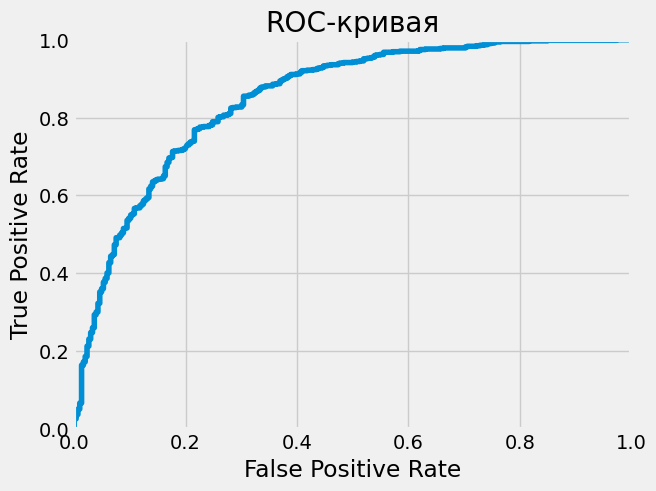

In [52]:
probabilities_test = cb.predict_proba(X_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)
plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show() 

In [53]:
# рассчитаем дополнительные метрики
print(f'Accuracy: {accuracy_score(y_test, predict_test)}')    
print(f'Полнота: {recall_score(y_test, predict_test)}')     
print(f'Точность: {precision_score(y_test, predict_test)}')  
print(f'F1-мера: {f1_score(y_test,predict_test)}')          
print(f'AUC-ROC:{roc_auc_score(y_test,probabilities_one_test)}')

Accuracy: 0.8084066471163245
Полнота: 0.9511854951185496
Точность: 0.8090154211150652
F1-мера: 0.8743589743589744
AUC-ROC:0.848971294701051


**Коды для тренировки, не смотреть**

In [ ]:

# Объединение числовых векторов с остальными признаками
text_features = ['title']
numerical_features = X_train.drop('lemm_text', axis=1).values


In [ ]:
feature_names = np.concatenate((X_train.drop('lemm_text', axis=1).columns)

X_train_transformed = np.concatenate((numerical_features,text,text_features), axis=1))

In [ ]:
# Объединение числовых и текстовых признаков
text_features = X_train['title']
numerical_features = X_train.drop(['lemm_text','title'], axis=1).values

# Получение имен признаков после объединения
feature_names = np.concatenate((X_train.drop('lemm_text', axis=1).columns, text_features))

X_train_transformed = np.concatenate((numerical_features, text), axis=1)

In [ ]:
X_train_transformed

In [ ]:
# Создание Pool с числовыми и текстовыми признаками
#cat_features = ['genres','language_y', 'year_of_track', 'country_of_track', 'reg_code']
train_pool = Pool(data=X_train_transformed, label=y_train)

In [ ]:
# численные признаки
#num_cols = X_train.select_dtypes(exclude='object').columns.to_list()
#num_cols

In [ ]:
# создадим переменную с категориальными признаками для передачи в модель
cat_features = X_train[['title','genres',
 'language_y',
 'year_of_track',
 'country_of_track',
 'reg_code']]
cat_features

In [ ]:
train_pool = Pool(data=X_train, label=y_train, text_features=text_features, cat_features=cat_features)


In [ ]:
# попробовать это
import numpy as np
from gensim.models import FastText
from catboost import CatBoostClassifier

# Загрузка предобученной модели FastText
fasttext_model = FastText.load('path/to/fasttext/model')

# Преобразование токенов в эмбеддинги с помощью модели FastText
X_text_embeddings = []
for text_tokens in X_text:
    text_embedding = np.mean([fasttext_model[token] for token in text_tokens], axis=0)
    X_text_embeddings.append(text_embedding)

# Преобразование эмбеддингов в формат, совместимый с CatBoost
X_text_embeddings = np.array(X_text_embeddings)

# Обучение модели CatBoostClassifier
model = CatBoostClassifier()
model.fit(X_text_embeddings, y_train)

Сырые коды

In [ ]:
# получаешь словарь номер столбца: название в словаре
dict_for_columns = {i[1]:i[0] for i in count_tf_idf.vocabulary_.items()}
new_df = pd.DataFrame.sparse.from_spmatrix(text).rename(columns=dict_for_columns)

In [ ]:
from collections import Counter

# Предположим, что у вас есть массив токенов
tokens = X_train['lemm_text']

# Выделение признаков с помощью метода TF-IDF
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(tokens).toarray()

# Подсчет частоты встречаемости слов в токенах
word_frequencies = Counter([word for token in tokens for word in token.split()])

# Определение 100 самых популярных слов
popular_words = [word for word, _ in word_frequencies.most_common(100)]

# Создание признаков на основе самых популярных слов
X_additional_features = []
for token in tokens:
    additional_features = [int(word in token.split()) for word in popular_words]
    X_additional_features.append(additional_features)

X_additional_features = np.array(X_additional_features)

# Объединение основных и дополнительных признаков
X_combined = np.concatenate((X_tfidf, X_additional_features), axis=1)

In [ ]:
# Оценка модели на тестовом наборе данных
predictions = model.predict(X_test_combined)

**Модель с остальными признаками и кроссвалидацией**

In [54]:
df_union.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10229 entries, 0 to 11096
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   original_track_id  10229 non-null  object        
 1   track_id           10229 non-null  object        
 2   track_remake_type  10229 non-null  object        
 3   dttm               10229 non-null  datetime64[ns]
 4   title              10229 non-null  object        
 5   language_x         10229 non-null  object        
 6   isrc               10229 non-null  object        
 7   genres             10229 non-null  object        
 8   duration           10229 non-null  float64       
 9   language_y         10229 non-null  object        
 10  lyricId            10229 non-null  object        
 11  lemm_text          10229 non-null  object        
 12  target             10229 non-null  int32         
 13  year_of_track      10229 non-null  object        
 14  countr

Подготовим признаки для обучения

In [55]:
df_union = df_union.drop(['original_track_id','track_id','dttm','lyricId','track_remake_type','isrc','language_x','lemm_text'], axis=1)

In [56]:
df_union.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10229 entries, 0 to 11096
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   title             10229 non-null  object 
 1   genres            10229 non-null  object 
 2   duration          10229 non-null  float64
 3   language_y        10229 non-null  object 
 4   target            10229 non-null  int32  
 5   year_of_track     10229 non-null  object 
 6   country_of_track  10229 non-null  object 
 7   reg_code          10229 non-null  object 
 8   year_of_entry     10229 non-null  int64  
dtypes: float64(1), int32(1), int64(1), object(6)
memory usage: 759.2+ KB


In [57]:
# cоздадим переменные для признаков и целевого признака
X = df_union.drop('target', axis=1)
y = df_union['target']

In [58]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=RANDOM_STATE,stratify = y
)

**Построим Baseline модель для последующей проверки наших моделей на адекватность**

In [69]:
dummy_model = DummyClassifier(strategy='constant', constant=1)
dummy_model.fit(X_train,y_train)
print(f'Dummy:{dummy_model.score(X_train,y_train)}')

Dummy:0.701173147946991


In [59]:
#численные признаки
num_cols = X_train.select_dtypes(exclude='object').columns.to_list()
num_cols

['duration', 'year_of_entry']

In [60]:
# создадим переменную с категориальными признаками для передачи в модель
cat_features = X_train.select_dtypes(include='object').columns.to_list()
cat_features

['title',
 'genres',
 'language_y',
 'year_of_track',
 'country_of_track',
 'reg_code']

In [ ]:
#text_features = X_train['title']

In [61]:
pipeline_catboost = Pipeline([
    ('cb', CatBoostClassifier(cat_features=cat_features,random_state=RANDOM_STATE))
])

parameters_catboost = {
    'cb__iterations': [100],
    'cb__depth': [3,6,9],
    'cb__learning_rate': [0.01, 0.15]
}

In [62]:
gs_model_cb = GridSearchCV(
    estimator = pipeline_catboost,
    param_grid=parameters_catboost, 
    scoring='roc_auc',
    cv=KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    n_jobs=-1)

In [63]:
%%time
gs_model_cb.fit(X_train, y_train)

0:	learn: 0.6151477	total: 54.5ms	remaining: 5.4s
1:	learn: 0.5582497	total: 94.6ms	remaining: 4.63s
2:	learn: 0.5143661	total: 160ms	remaining: 5.17s
3:	learn: 0.4784847	total: 242ms	remaining: 5.8s
4:	learn: 0.4441284	total: 313ms	remaining: 5.95s
5:	learn: 0.4168444	total: 378ms	remaining: 5.92s
6:	learn: 0.3932635	total: 442ms	remaining: 5.87s
7:	learn: 0.3745947	total: 521ms	remaining: 5.99s
8:	learn: 0.3589536	total: 590ms	remaining: 5.96s
9:	learn: 0.3457455	total: 636ms	remaining: 5.73s
10:	learn: 0.3340666	total: 684ms	remaining: 5.53s
11:	learn: 0.3241927	total: 732ms	remaining: 5.36s
12:	learn: 0.3157595	total: 793ms	remaining: 5.3s
13:	learn: 0.3092586	total: 901ms	remaining: 5.54s
14:	learn: 0.3022684	total: 955ms	remaining: 5.41s
15:	learn: 0.2966726	total: 1.01s	remaining: 5.32s
16:	learn: 0.2914190	total: 1.06s	remaining: 5.18s
17:	learn: 0.2876053	total: 1.11s	remaining: 5.06s
18:	learn: 0.2834697	total: 1.17s	remaining: 4.97s
19:	learn: 0.2798726	total: 1.22s	remainin

GridSearchCV(cv=KFold(n_splits=5, random_state=54321, shuffle=True),
             estimator=Pipeline(steps=[('cb',
                                        <catboost.core.CatBoostClassifier object at 0x0000022E2C004A60>)]),
             n_jobs=-1,
             param_grid={'cb__depth': [3, 6, 9], 'cb__iterations': [100],
                         'cb__learning_rate': [0.01, 0.15]},
             scoring='roc_auc')

In [64]:
# выведем лучшие значения гиперпараметров, полученные на GridSearch
best_model_cb = gs_model_cb.best_estimator_

gs_model_cb_best_score = gs_model_cb.best_score_
gs_model_cb_best_params = gs_model_cb.best_params_

print(f'Best params CatBoostClassifier: {gs_model_cb_best_params}')
print(f'ROC-AUC CatBoostClassifier: {gs_model_cb_best_score}')

Best params CatBoostClassifier: {'cb__depth': 9, 'cb__iterations': 100, 'cb__learning_rate': 0.15}
ROC-AUC CatBoostClassifier: 0.9623909651780596


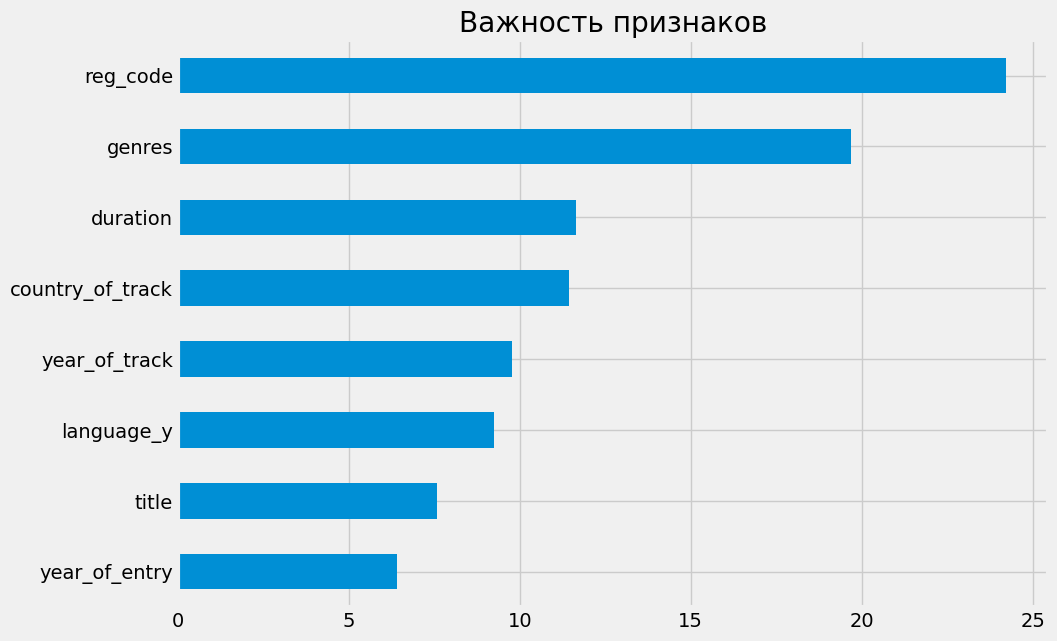

In [65]:
# построим гистограмму значимости признаков для модели CatBoost
# значения отсортированные по возрастанию влияния

plt.figure(figsize = (10,7))
importances = pd.Series(best_model_cb.named_steps['cb'].feature_importances_,index=best_model_cb['cb'].feature_names_).sort_values()

# график
importances.plot.barh(grid=True, title='Важность признаков');

In [66]:
predict_test = best_model_cb.predict(X_test)

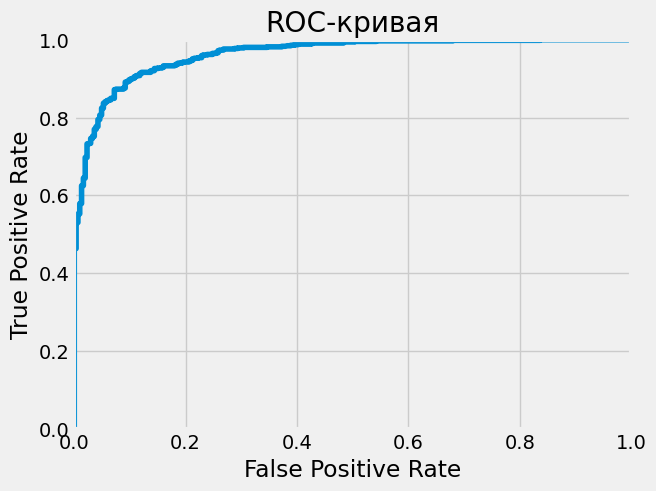

In [67]:
probabilities_test = best_model_cb.predict_proba(X_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)
plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show() 

In [68]:
# рассчитаем дополнительные метрики
print(f'Accuracy: {accuracy_score(y_test, predict_test)}')    
print(f'Полнота: {recall_score(y_test, predict_test)}')     
print(f'Точность: {precision_score(y_test, predict_test)}')  
print(f'F1-мера: {f1_score(y_test,predict_test)}')          
print(f'AUC-ROC:{roc_auc_score(y_test,probabilities_one_test)}')

Accuracy: 0.9022482893450635
Полнота: 0.9400278940027894
Точность: 0.9220246238030095
F1-мера: 0.930939226519337
AUC-ROC:0.9627054447999562


**Метрики при удаленных столбцах**
df_union = df_union.drop(['original_track_id','track_id','dttm','lyricId','track_remake_type','text','genres'], axis=1)
Accuracy: 0.9010946051602815   
Полнота: 0.9498327759197325   
Точность: 0.9126941617568292   
F1-мера: 0.9308931985796232   
AUC-ROC:0.9553569344002988   
Dummy:0.7010819971320558

**Метрики при удаленных столбцах**
df_union = df_union.drop(['original_track_id','track_id','dttm','lyricId','track_remake_type','text','genres','isrc'], axis=1)
Accuracy: 0.9007036747458952   
Полнота: 0.9403567447045708   
Точность: 0.9198473282442748   
F1-мера: 0.9299889746416758   
AUC-ROC:0.9518103538846767   

In [ ]:
dummy_model = DummyClassifier(strategy='constant', constant=1)
dummy_model.fit(X_train,y_train)
print(f'Dummy:{dummy_model.score(X_train,y_train)}')

**Идея для реализации**

Подход №1: глубокая предобработка данных

1. Подготовка данных. Транслитерацию перевели на родной язык. Очистили тексты от мусора. 

2. Перевод данных в эмбеддинги. С помощью предобученной библиотеки navic перевести токены в эмбеддинги. Navic выбрали из-за объёма и скорости: она в 10 раз быстрее и компактнее аналогов. Переводим наши токены в эмбейдинги с помощью navic.Уточнить с чем работает navic.

3. Добавление признаков. Сконвертировать текстовые данные в числовые, сохранив их смысл. Определить 100 самых популярных слов в токенах. Выделили их в отдельные признаки, тем самым увеличив датасет. Выбрать и обучить модель. 
